In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [296]:
dataNBA = pd.read_csv("all_seasons.csv").loc[:,["player_height", "player_weight"]]
dataNBA = np.random.permutation(dataNBA.values)[:int(0.02* dataNBA.shape[0])]
dataNBA = dataNBA[dataNBA[:,1] < 120]

x = dataNBA[:,0].reshape(-1,1)
y = dataNBA[:,1]

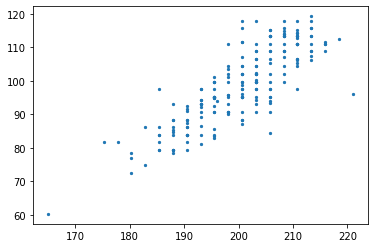

In [297]:
plt.scatter(x, y, s = 5)

In [298]:
dataNBAtrunc = pd.read_csv("all_seasons.csv").loc[:,["player_height", "player_weight"]]
dataNBAtrunc = np.random.permutation(dataNBAtrunc.values)[:int(0.6* dataNBA.shape[0])]
dataNBAtrunc = dataNBAtrunc[dataNBAtrunc[:,1] > 110]
dataNBAtrunc = dataNBAtrunc[dataNBAtrunc[:,1] < 120]

x_trunc = dataNBAtrunc[:,0].reshape(-1,1)
y_trunc = dataNBAtrunc[:,1]

In [299]:
def pad_ones(x):
    placeholder = np.zeros((x.shape[0], 2))
    placeholder[:, 0] = np.ones(x.shape[0])
    placeholder[:, 1] = x[:,0]
    return placeholder

from sklearn.preprocessing import scale

x = scale(x, axis=0)
x_trunc = scale(x_trunc, axis=0)

x_padded = pad_ones(x)
xtrunc_padded = pad_ones(x_trunc)
y = scale(y)
y_trunc = scale(y_trunc)

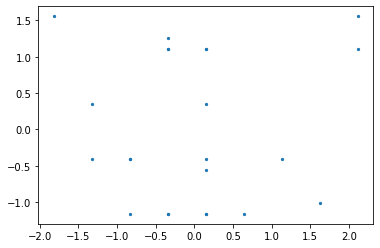

In [300]:
plt.scatter(x_trunc, y_trunc, s = 5)

Model 1 slope:     0.8290785087248883
Model 1 intercept: 6.482093707145869e-16
Model 2 slope:     0.05129606641030624
Model 2 intercept: 5.24761222704553e-15


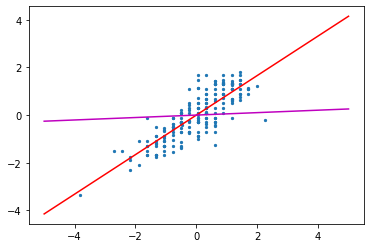

In [302]:
from sklearn.linear_model import LinearRegression

model1 = LinearRegression(fit_intercept=True)
model2 = LinearRegression(fit_intercept=True)

model1.fit(x, y)
model2.fit(x_trunc, y_trunc)

xfit = np.linspace(-5, 5, 1000)
yfit1 = model1.predict(xfit[:, np.newaxis])
yfit2 = model2.predict(xfit[:, np.newaxis])

plt.scatter(x, y, s= 5)
plt.plot(xfit, yfit1, c="r");
plt.plot(xfit, yfit2, c="m");


print("Model 1 slope:    ", model1.coef_[0])
print("Model 1 intercept:", model1.intercept_)

print("Model 2 slope:    ", model2.coef_[0])
print("Model 2 intercept:", model2.intercept_)

In [303]:
def mean_square_difference(y, y_pred):
    return np.mean((y-y_pred)**2)

sigma_squared_hat = mean_square_difference(y, model1.predict(x))
print(sigma_squared_hat)

0.31262882637051476


In [310]:
from scipy.stats import multivariate_normal as normal

cov_matrix = np.identity(2)

sigma_slope_and_intercept_squared = 0.01

cov_matrix[0,0] *= sigma_slope_and_intercept_squared
cov_matrix[1,1] *= sigma_slope_and_intercept_squared


prior_on_parameters = normal(np.array([0, 0]), cov_matrix)

In [311]:
def predictive_model(params, x):
    try:
        return np.dot(params, x)
    except ValueError as VE:
        return params[0] + params[1] * x

Model 1 slope:     0.8290785087248883
Model 1 intercept: 6.482093707145869e-16
Model 2 slope:     0.05129606641030624
Model 2 intercept: 5.24761222704553e-15


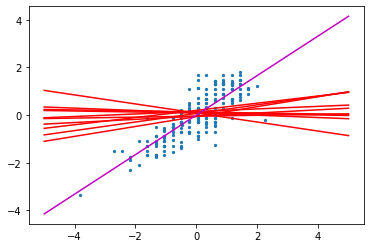

In [313]:
xfit = np.linspace(-5, 5, 1000)

plt.scatter(x, y, s= 5)

for sampled_parameters in prior_on_parameters.rvs(size=10):
    plt.plot(xfit, predictive_model(sampled_parameters, xfit), c="r");

    
plt.plot(xfit, yfit1, c="m");

print("Model 1 slope:    ", model1.coef_[0])
print("Model 1 intercept:", model1.intercept_)

print("Model 2 slope:    ", model2.coef_[0])
print("Model 2 intercept:", model2.intercept_)

In [315]:
def update_prior(x, y, sigma_parameter_squared, sigma_model_squared):
    xTx = np.dot(x.T, x)
    xTy = np.dot(x.T, y)
    
    new_cov_matrix = np.linalg.inv( (1/sigma_parameter_squared) * np.identity(2) + (1/sigma_model_squared) * xTx )
    new_mean = (1/sigma_model_squared) * np.dot(new_cov_matrix, xTy)   
    
    return new_mean, new_cov_matrix

In [316]:
new_parameters = update_prior(x_padded, y, sigma_slope_and_intercept_squared, sigma_squared_hat)
posterior_on_parameters = normal(new_parameters[0], new_parameters[1], cov_matrix)
print(new_parameters)

(array([4.43092372e-16, 7.20748358e-01]), array([[1.30663320e-03, 2.02807826e-18],
       [2.02807826e-18, 1.30663320e-03]]))


Model 1 slope:     0.8290785087248883
Model 1 intercept: 6.482093707145869e-16
Model 2 slope:     0.05129606641030624
Model 2 intercept: 5.24761222704553e-15


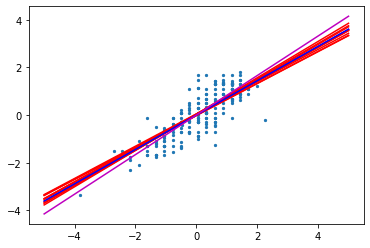

In [317]:
xfit = np.linspace(-5, 5, 1000)

plt.scatter(x, y, s= 5)

for sampled_parameters in posterior_on_parameters.rvs(size=10):
    plt.plot(xfit, predictive_model(sampled_parameters, xfit), c="r");

plt.plot(xfit, predictive_model(new_parameters[0], xfit), c="b")

plt.plot(xfit, yfit1, c="m");

print("Model 1 slope:    ", model1.coef_[0])
print("Model 1 intercept:", model1.intercept_)

print("Model 2 slope:    ", model2.coef_[0])
print("Model 2 intercept:", model2.intercept_)

In [322]:
def likelihood(parameter_values, x, y):
    prod = 1
    for i in range(x.shape[0]):
        p_point = normal(np.dot(parameter_values[0], x[i]), parameter_values[1]).pdf(y[i])
        prod *= 2*p_point
    return prod

In [323]:
likelihood([np.array([0, 0.8336]), sigma_squared_hat], x_padded, y)

8.931717177304126e-14

In [337]:
def rejection_sampling_algorithm():
    output = []
    while len(output) < 10:
        samples = prior_on_parameters.rvs(size=10)
        for sample in samples:
            bit = np.random.uniform(0,1)
            L = likelihood([np.array(sample), sigma_squared_hat], x_padded, y)
            if bit < L/ (8.931717177304126e-14):
                output.append(sample)
                print("sampled")
            else:
                print(L)
    return output
posterior_sample = rejection_sampling_algorithm()
print(posterior_sample)

7.792292046336263e-163
6.9866226758433176e-99
8.328932597612979e-122
3.623543225468567e-107
7.288598266135108e-122
7.486985805443528e-107
8.853117676350998e-142
5.469641767998896e-152
3.613491680191755e-83
1.3436332466185288e-151
1.9094484334091254e-113
3.25454015559461e-121
1.7153415958153608e-130
1.1854176258252786e-146
1.7112371777216927e-129
8.933664287188662e-88
1.0550139029645431e-98
1.660237155357056e-121
1.794716381824642e-79
3.091762593853364e-101
1.4947949606741847e-90
7.467121247067981e-97
1.1454113932249218e-119
2.348756736842333e-142
3.160857983588104e-95
1.799715127618285e-122
3.0628695081348355e-120
2.4006869175582655e-143
3.687445276840277e-166
3.2758812574583774e-124
7.22695975537097e-98
4.2932197490647906e-106
3.771816341211391e-107
2.085092307640026e-134
6.313057662466585e-73
1.5069030802684762e-108
1.8827019359237442e-140
1.1571405469074176e-113
1.8064963548359507e-135
1.386828940091778e-111
4.342612771953637e-97
8.372908203939047e-153
1.000423734345855e-85
5.777850

KeyboardInterrupt: 

Model 1 slope:     0.8290785087248883
Model 1 intercept: 6.482093707145869e-16
Model 2 slope:     0.05129606641030624
Model 2 intercept: 5.24761222704553e-15


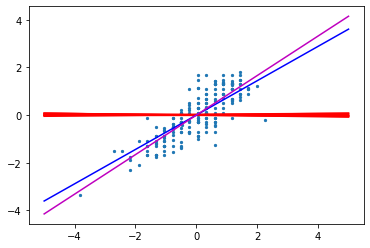

In [338]:
xfit = np.linspace(-5, 5, 1000)

plt.scatter(x, y, s= 5)

for sampled_parameters in posterior_sample:
    plt.plot(xfit, predictive_model(sampled_parameters, xfit), c="r");

plt.plot(xfit, predictive_model(new_parameters[0], xfit), c="b")

plt.plot(xfit, yfit1, c="m");

print("Model 1 slope:    ", model1.coef_[0])
print("Model 1 intercept:", model1.intercept_)

print("Model 2 slope:    ", model2.coef_[0])
print("Model 2 intercept:", model2.intercept_)